# Steps for Text Generation
- first preprocess data
- second make training sequances dataset by [seq] -> next char as lable
- make this pairs 
- apply char embedding
- train LSTM model but it may a problem how to handle output from first seq as input for next sequance in lstm 
- firstful we try with const seq_lenth -> after const number of character generate one char in this time its=15
- train model 
- test model 


In [1]:
!pip install -U wikipedia
import numpy as np
import wikipedia as wiki
import spacy
import re
import tqdm
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical  
import warnings
warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=4d3e033fd5fd4ee128f28fc52d4c6763eaf70f38a6467bdc9b80926990fc90dd
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


2024-05-08 10:48:07.206267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 10:48:07.206394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 10:48:07.346005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing 

In [2]:
def process_text(document):
      nlp = spacy.load('en_core_web_sm')
      stopwords = nlp.Defaults.stop_words
      document = re.sub(r'\s+', ' ', document, flags=re.I)  
      document = re.sub(r'\W', ' ', str(document))  
      document = re.sub(r'_', ' ', str(document)) 
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  
      document = document.lower()
      document = re.sub(r'\s+', ' ', document, flags=re.I)  
      doc_spacy = nlp(document)
      lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
      lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
      lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]  
      clean_txt = ' '.join(lemma_no_stop_txt)
      clean_sents_list = [x for x in nlp(clean_txt).sents]
      return clean_sents_list, clean_txt, lemma_no_stop_txt

# Collect  Data From wikipedia and Arxiv research papers

In [3]:
# Download data (replace with your data acquisition method)
wiki.set_lang('en')

wiki_obj = wiki.page(wiki.search(['Large Language Models deep learning ', 'newest Large Language Models deep learning', 'attention mechanism ', 'transformers in Deep learning']))
data = wiki_obj.content
clean_sents_list, x_train_sents, x_train_clean_txt = process_text(data)


100%|██████████| 2134/2134 [00:00<00:00, 516512.48it/s]


In [4]:
x_train_sents

'generative train transformer type large language model prominent framework generative artificial intelligence artificial neural network natural language processing task base transformer architecture train large data unlabelled text able generate novel human like content 2023 characteristic refer broadly introduce 2018 openai openai release influential foundation model sequentially number comprise series significantly capable previous increase size number trainable parameter train recent release march 2023 model basis task specific system include model fine tune instruction follow turn power chatgpt chatbot service term description model develop example foundation model include series model create eleutherai seven model create cerebra 2023 company different industry develop task specific respective field salesforce einsteingpt bloomberg bloomberggpt finance history initial development generative pretraine long establish concept machine learning application originally form semi supervis

In [5]:
# [token_sent.text for token_sent in clean_sents_list][1]

In [7]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=0b0bc2e0d50861551388eaaaf87439c93b3be03e427bb767aa9cf7ecac75eb46
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [8]:
import arxiv

# Search for articles related to "Large Language Models" (LLMs)
llm_search = arxiv.Search(query=['Large Language Models deep learning '], max_results=100)
llm_results = list(llm_search.results())

llm_papers = ""  

print("Articles related to Large Language Models:")
for result in llm_results:
    llm_papers += f"Title: {result.title}\n\nAbstract: {result.summary}\n\n"  


transformer_search = arxiv.Search(query="Transformers in deep learning", max_results=100)
transformer_results = list(transformer_search.results())

transformer_papers = ""  

print("\nArticles related to Transformers in deep learning:")
for result in transformer_results:
    transformer_papers += f"{result.title}Abstract: {result.summary}"  

all_papers = llm_papers + transformer_papers
# print(all_papers)
data=all_papers+ ' '+ data

Articles related to Large Language Models:

Articles related to Transformers in deep learning:


In [9]:
clean_sents_list, x_train_sents, x_train_clean_txt = process_text(data)

100%|██████████| 19934/19934 [00:00<00:00, 518275.60it/s]


# Creat Training pairs Char_Based_GEN_model

In [10]:
Seq_length=300
def create_dataset(text_data, seq_length=Seq_length):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []
  for i in range(0, len(text_data) - seq_length, 1):
    seq_in = text_data[i:i + seq_length]  
    seq_out = text_data[i + seq_length]  

    X_data.append([char_to_int[char] for char in seq_in])
  
    y_data.append(char_to_int[seq_out])
    
  return np.array(X_data),np.array(y_data),len(chars)


In [11]:
X,y,char_unique_size=create_dataset(x_train_sents,seq_length=15)
y=y.reshape(len(y),1)
x_catagorical=tensorflow.keras.utils.to_categorical(X)
y_catagorical=tensorflow.keras.utils.to_categorical(y)

y.shape

(98081, 1)

In [12]:
char_unique_size

38

# Char Baased GEN Model

In [13]:
model = tensorflow.keras.Sequential([
  Embedding(char_unique_size, 124),
#   Dropout(0.5),
  GRU(520, return_sequences=True),
  Bidirectional(layer=GRU(340, return_sequences=True,activation='tanh')),
  GlobalMaxPooling1D(),
  Dense(1024, activation='elu'),
  Dense(char_unique_size, activation='softmax'),  
])

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history=model.fit(X,y,epochs=7,batch_size=100)

Epoch 1/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.3191 - loss: 2.2914
Epoch 2/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6019 - loss: 1.3148
Epoch 3/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6723 - loss: 1.0641
Epoch 4/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7070 - loss: 0.9335
Epoch 5/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7250 - loss: 0.8566
Epoch 6/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7529 - loss: 0.7674
Epoch 7/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7736 - loss: 0.6950


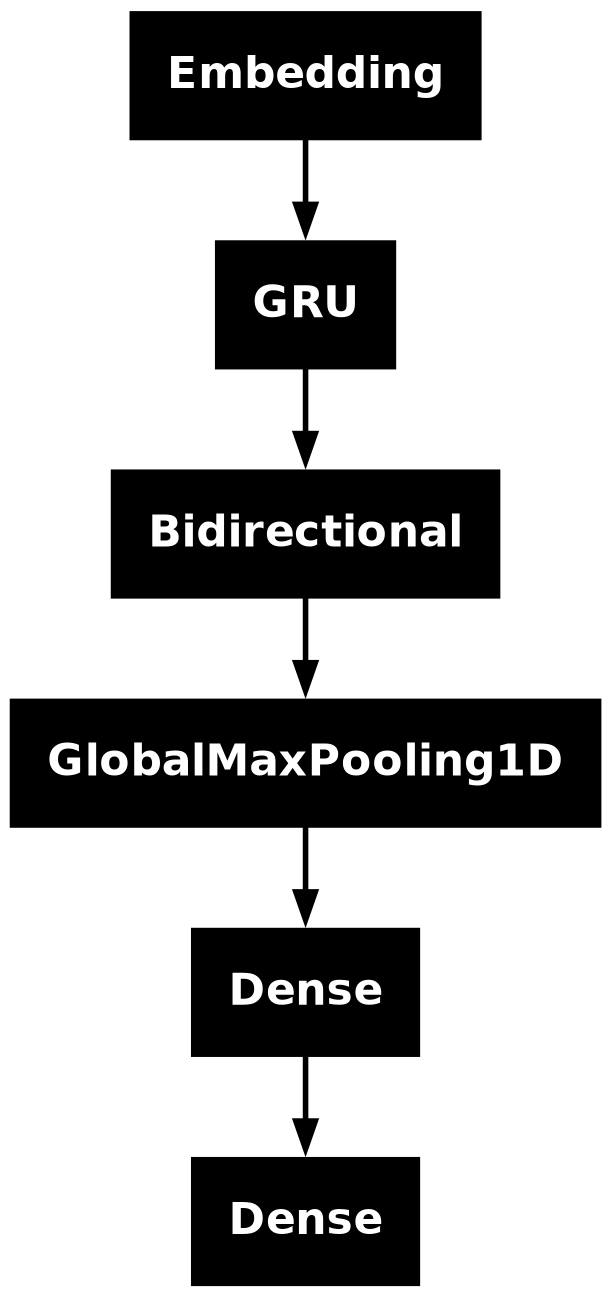

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model,'/kaggle/working/model2.png')

# Eval

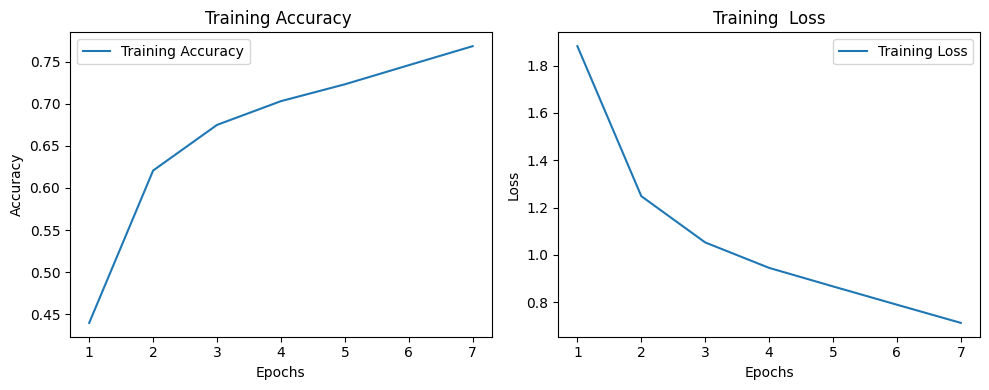

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
#     val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
#     plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy ')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
#     plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training  Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' contains your training history
# Call the function to plot the training history
plot_training_history(history)


In [38]:
def test_predictio_random_char_based_model_gen(model=model, input_text=x_train_sents, seq_length=Seq_length):
    all_text = input_text
    chars= [char for char in input_text]  # Can be commented out if not needed later
    
    if len(chars) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None
    
    random_start_index = np.random.randint(0, len(chars) - seq_length)
    input_text = all_text[random_start_index:random_start_index + seq_length]  # Extract sequence
    print(f'testing portion is ---> {input_text}')

    unique_chars = sorted(list(set(chars)))  # Use words if needed, otherwise remove this line

    word_to_int = {w: i for i, w in enumerate(unique_chars)}
    int_to_word = {i: w for i, w in enumerate(unique_chars)}

    input_seq = [word_to_int[word] for word in input_text]
    input_seq = np.array(input_seq).reshape(1, seq_length)
    prediction = model.predict(input_seq)

    print(f'true char is {all_text[random_start_index + seq_length]}')
    return int_to_word[np.argmax(prediction)]

In [37]:
test_predictio_random_char_based_model_gen()

testing portion is ---> ity propose layer machine learn brain disorder transformer visual transformersabstract transformer initially introduce natural language processing task fast adopt deep learn field include computer vision measure relationship pair input token word case text string image visual transformer term attent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
true word is i


'i'

In [40]:
# its only try but take big running Duration
def create_dataset_all_sequences(text_data):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []

  # Loop through all starting positions in the text data
  for start_index in range(len(text_data)):
    # Loop through sequence lengths from 1 to a maximum length (can be adjusted)
    for seq_len in range(1, len(text_data) - start_index + 1):
      # Create input sequence
      input_seq = [char_to_int[char] for char in text_data[start_index:start_index + seq_len]]
      # Create target sequence (shifted by 1 character)
      target_seq = [char_to_int[char] for char in text_data[start_index + 1:start_index + seq_len + 1]]
      X_data.append(input_seq)
      y_data.append(target_seq)
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  return X_data, y_data, char_to_int


In [ ]:
# X_dynamic_sequances,y_dynamic_sequances,char_unique_size=create_dataset_all_sequences(x_train_sents)
# # y_dynamic_sequances=y_dynamic_sequances.reshape(len(y_dynamic_sequances),1)
# X_dynamic_sequances.shape

# word Based generator training model

In [ ]:
x_train_sents.split()

In [42]:
import numpy as np

Words_Seq_length = 5

def create_dataset_word_based(text_data=x_train_sents, seq_length=Words_Seq_length):
    words = text_data.split()
    unique_words = sorted(set(words))
    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    X_data_words = []
    y_data_words = []
    for i in range(len(words) - seq_length):
        seq_in = words[i:i + seq_length]
        seq_out = words[i + seq_length]
        X_data_words.append([word_to_int[word] for word in seq_in])
        y_data_words.append(word_to_int[seq_out])
#     z=[int_to_word[word]for word in X_data_words[0]]
#     print(z)
    return np.array(X_data_words), np.array(y_data_words), len(unique_words)


In [43]:
X_wordSeq_training,Y_wordSEQ_training,UNique_words_len=create_dataset_word_based()

In [44]:
model_word_generation = tensorflow.keras.Sequential()
model_word_generation.add(Embedding(UNique_words_len, 312))
model_word_generation.add(LSTM(256, input_shape=(X.shape[1], 312),return_sequences=True))
model_word_generation.add(Dropout(0.2))
model_word_generation.add(LSTM(256))
model_word_generation.add(Dropout(0.2))
model_word_generation.add(Dense(UNique_words_len, activation='softmax'))
model_word_generation.compile(loss='categorical_crossentropy', optimizer='adam')


In [45]:
model_word_generation.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model_word_generation.fit(X_wordSeq_training,Y_wordSEQ_training,epochs=20,batch_size=50)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0300 - loss: 7.1508
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0395 - loss: 6.5928
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0494 - loss: 6.4557
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0585 - loss: 6.2361
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0710 - loss: 5.9903
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0714 - loss: 5.6974
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0902 - loss: 5.3603
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1122 - loss: 4.9203
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1405 - loss: 4.5159
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2026 - loss: 4.0894
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2647 - loss: 3.6837
Epoch 12/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [47]:
def test_prediction_random_word_based_model_gen(model=model_word_generation, input_text=x_train_sents, seq_length=Words_Seq_length):
    all_text = input_text
    words = input_text.split()  # Can be commented out if not needed later
    
    if len(words) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None
    
    random_start_index = np.random.randint(0, len(words) - seq_length)
    input_text = words[random_start_index:random_start_index + seq_length]  # Extract sequence
    print(f'testing portion is ---> {input_text}')

    unique_words = sorted(list(set(words)))  # Use words if needed, otherwise remove this line

    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    input_seq = [word_to_int[word] for word in input_text]
    input_seq = np.array(input_seq).reshape(1, seq_length)
    prediction = model.predict(input_seq)

    print(f'true word is {all_text.split()[random_start_index + seq_length]}')
    return int_to_word[np.argmax(prediction)]


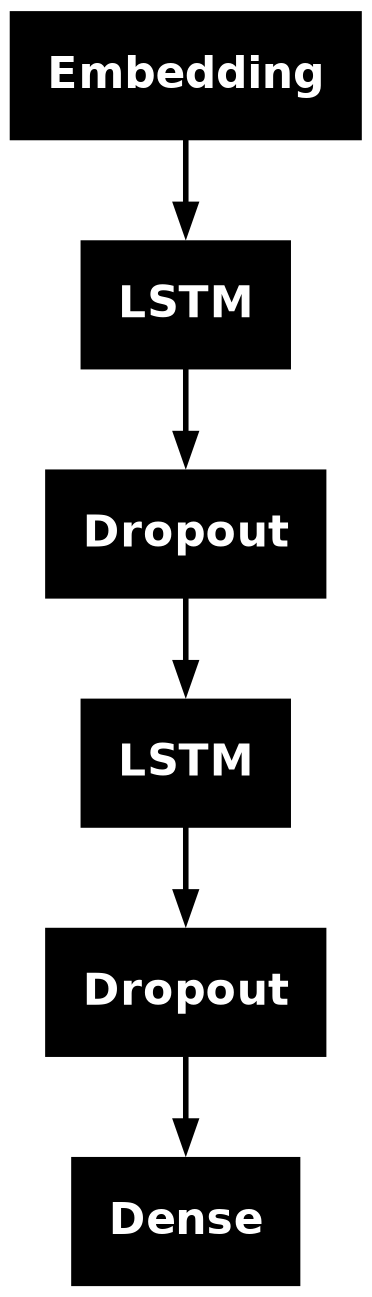

In [48]:
plot_model(model_word_generation,'/kaggle/working/model_word_gen.png')

In [49]:
test_prediction_random_word_based_model_gen()

testing portion is ---> ['fine', 'grain', 'image', 'representation', 'block']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
true word is uniformly


'uniformly'